In [1]:
## disabeling warning msg
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import warnings
warnings.simplefilter('ignore')
import sys
sys.stdout.flush() # resolving tqdm problem

# Model

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

E0000 00:00:1760073794.652100      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760073794.713706      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
#####################################################################################
def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
#####################################################################################################################
def mse_score(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [4]:
def dual_decoder_unet_binary(IMG_CHANNELS, LearnRate):
    inputs = Input((None, None, IMG_CHANNELS))
    #encoder
    s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)


    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    ## decoder for dis unet
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs1 = Conv2D(1, (1, 1), activation='linear', name='output_dis')(c9)


    ## decoder for segmentation unet
    u6_seg = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_seg = concatenate([u6_seg, c4])
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_seg)
    c6_seg = Dropout(0.2)(c6_seg)
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_seg)

    u7_seg = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_seg)
    u7_seg = concatenate([u7_seg, c3])
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_seg)
    c7_seg = Dropout(0.2)(c7_seg)
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_seg)

    u8_seg = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_seg)
    u8_seg = concatenate([u8_seg, c2])
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_seg)
    c8_seg = Dropout(0.1)(c8_seg)
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_seg)

    u9_seg = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_seg)
    u9_seg = concatenate([u9_seg, c1], axis=3)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_seg)
    c9_seg = Dropout(0.1)(c9_seg)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_seg)

    outputs2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_seg')(c9_seg)

    model_dual_path = models.Model(inputs=[inputs], outputs=[outputs1, outputs2])
    model_dual_path.compile(optimizer=Adam(learning_rate=LearnRate),
                            loss={'output_dis': 'mean_squared_error', 'output_seg': bce_dice_loss},
                            loss_weights=  {'output_dis': 1.0, 'output_seg': 1.0},
                            metrics={'output_seg':dice_coef, 'output_dis':mse_score})
    # model_dual_path.summary()
    return model_dual_path

In [5]:
#x = dual_decoder_unet_binary(3,0.001)

In [6]:
#x.summary()

In [19]:
# set all hyper parameters
opts = {}
opts['number_of_channel'] = 3                   
opts['treshold'] = 0.5                          
opts['epoch_num'] = 5 #120                   
opts['quick_run'] = 1   
opts['batch_size'] = 8                         
opts['random_seed_num'] = 19   
opts['k_fold'] = 2                          
opts['save_val_results'] = 1         
opts['init_LR'] = 0.001                         
opts['LR_decay_factor'] = 0.5                   
opts['LR_drop_after_nth_epoch'] = 20            
opts['crop_size'] = 512   
## output directories
opts['result_save_path'] ='/kaggle/working/prediction_image/'
opts['model_save_path'] ='/kaggle/working/output_model/'

In [8]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.1, epochs_drop=20):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/epochs_drop))
    
    return LearningRateScheduler(schedule, verbose = 1)

# Data Preperation

In [9]:
base_path = '../input/nuinsseg/'
organ_names = [ name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) ]
organ_names

['mouse muscle_tibia',
 'mouse liver',
 'human liver',
 'human umbilical cord',
 'mouse thymus',
 'human lung',
 'human epiglottis',
 'human spleen',
 'mouse fat (white and brown)_subscapula',
 'human cardia',
 'human salivory gland',
 'human melanoma',
 'human kidney',
 'human pylorus',
 'human jejunum',
 'human testis',
 'mouse spleen',
 'human tongue',
 'human cerebellum',
 'human oesophagus',
 'mouse heart',
 'human pancreas',
 'human brain',
 'human muscle',
 'human placenta',
 'human bladder',
 'mouse kidney',
 'human tonsile',
 'human rectum',
 'mouse femur',
 'human peritoneum']

In [10]:
import os
from glob import glob

img_path = glob('{}*{}'.format('../input/nuinsseg/*/tissue images/', 'png'))
binary_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/mask binary/', 'png'))
distance_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/distance maps/', 'png'))
label_mask_path = glob('{}*{}'.format('../input/nuinsseg/*/label masks modify/', 'tif'))
vague_mask_path =  glob('{}*{}'.format('../input/nuinsseg/*/vague areas/mask binary/', 'png'))


img_path.sort()
binary_mask_path.sort()
distance_mask_path.sort()
label_mask_path.sort()
vague_mask_path.sort()


# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('/kaggle/working/prediction_image/'):
    os.makedirs('/kaggle/working/prediction_image/')
if not os.path.exists('/kaggle/working/output_model/'):
    os.makedirs('/kaggle/working/output_model/')    
if not os.path.exists(opts['result_save_path']+ 'validation/unet'):
    os.makedirs(opts['result_save_path'] + 'validation/unet')
if not os.path.exists(opts['result_save_path']+ 'validation/watershed_unet'):
    os.makedirs(opts['result_save_path'] + 'validation/watershed_unet')  


In [11]:
#random check
import numpy as np
import random
rand_num = np.random.randint(len(img_path))
print('image path: {}\n'.format(img_path[rand_num]),
      'binary mask path: {}\n'.format(binary_mask_path[rand_num]),
      'distance mask path: {}\n'.format(distance_mask_path[rand_num]),
      'label mask path: {}\n'.format(label_mask_path[rand_num]))

image path: ../input/nuinsseg/mouse liver/tissue images/mouse_liver_10.png
 binary mask path: ../input/nuinsseg/mouse liver/mask binary/mouse_liver_10.png
 distance mask path: ../input/nuinsseg/mouse liver/distance maps/mouse_liver_10.png
 label mask path: ../input/nuinsseg/mouse liver/label masks modify/mouse_liver_10.tif



# KFold

In [12]:
from random import shuffle
import cv2
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint

In [13]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = KFold(n_splits= opts['k_fold'],random_state= opts['random_seed_num'],shuffle=True)
kf.get_n_splits(img_path)

2

In [21]:
## Data Generator Needed not to run out of 
def chunker(seq, seq2, seq3, size):
    return ([seq[pos:pos + size], seq2[pos:pos + size], seq3[pos:pos + size]] for pos in range(0, len(seq), size))

def data_gen(list_files, list_files2, list_files3, batch_size, p , size_row, size_col, distance_unet_flag = 0,
             augment= False, BACKBONE_model = None, use_pretrain_flag = 1):
    while True:
        for batch in chunker(list_files, list_files2, list_files3, batch_size):
            Y = []
            Y_seg = []
            Y_dis = []
            X = []
            
            image_paths = batch[0]
            mask_paths = batch[1]
            dis_paths = batch[2] 

            for count in range(len(image_paths)):
                # 1. Load Image (X)
                x = cv2.imread(image_paths[count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                
                # 2. Load Segmentation Mask (Y_seg) - For output_seg
                seg_mask = cv2.imread(mask_paths[count], cv2.IMREAD_GRAYSCALE)
                
                # 3. Load Distance Map (Y_dis) - For output_dis
                dis_map = cv2.imread(dis_paths[count], cv2.IMREAD_GRAYSCALE)

                x = x.astype(np.float32)
                x = x/255.0
                
                seg_mask = (seg_mask > 0).astype(np.float32) 
                
                # Normalize distance map (Regression: 0.0 to 1.0)
                # Your old distance normalization logic (good for distance maps):
                dis_map = dis_map.astype(np.float32)
                min_dis = np.min(dis_map)
                max_dis = np.max(dis_map)
                dis_map = (dis_map - min_dis) / (max_dis - min_dis + 0.0000001)

                X.append(x)
                Y_seg.append(seg_mask)
                Y_dis.append(dis_map)
                
                del x, seg_mask, dis_map
            X = np.array(X)
            Y_seg = np.expand_dims(np.array(Y_seg), axis=-1)
            Y_dis = np.expand_dims(np.array(Y_dis), axis=-1)
            yield X, {'output_seg': Y_seg, 'output_dis': Y_dis}
                

In [22]:
current_fold = 1


for index,[train_index,  test_index] in enumerate(kf.split(img_path)):
    
    # print(train_index,"\n========================\n",test_index,"\n==========================\n")
    shuffle(train_index)
    shuffle(test_index)
    # print(train_index,"\n======================\n",test_index)
    
    train_img   = [img_path[name] for name in train_index]
    train_mask  = [binary_mask_path[name] for name in train_index]
    train_DIS   = [distance_mask_path[name] for name in train_index]

    # train_imgs = []
    # train_masks = []
    # train_DISTS = []

    # Does not work for large datasets, need to use generators.
    # print(train_img[0])
    # for idx,img in enumerate(train_img):
    #     # print(idx)
    #     #preprocessing
    #     img = cv2.imread(img)
    #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #     # img = val_img/255
    #     img = img.astype(np.float32) / 255.0 
    #     train_imgs.append(img)
        
    #     # mask = cv2.imread(train_mask[idx], -1) 
    #     # train_masks.append(mask)
    #     mask_path = train_mask[idx]
    #     mask = cv2.imread(mask_path, -1)
    #     # Convert mask to float32 and normalize (usually 0.0 or 1.0 for binary masks)
    #     mask = mask.astype(np.float32) / 255.0 
    #     train_masks.append(mask)
        
    #     # dist = cv2.imread(train_DIS[idx], -1) 
    #     # train_DISTS.append(dist)
    #     dis_path = train_DIS[idx]
    #     dist = cv2.imread(dis_path, -1)
    #     # Convert distance map to float32 and normalize (assuming 0-255 range)
    #     dist = dist.astype(np.float32) / 255.0 
    #     train_DISTS.append(dist)

    # train_img = np.array(train_imgs)
    # train_mask = np.array(train_masks)
    # train_mask = np.expand_dims(train_mask, axis=-1)
    # train_DIS = np.array(train_DISTS)
    # train_DIS = np.expand_dims(train_DIS, axis=-1)
        

    test_img   = [img_path[name] for name in test_index]
    test_mask  = [binary_mask_path[name] for name in test_index]
    test_DIS   = [distance_mask_path[name] for name in test_index]

    #creating validation set
    validation_set_img = []
    # validation_set_label = []
    validation_DIS = []
    # validation_set_vague = []
    # test_masks = []
    
    for counter in range(len(test_img)):
        val_img = cv2.imread(test_img[counter])
        val_img = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
        val_img = val_img.astype(np.float32) / 255.0 
        validation_set_img.append(val_img)
        # val_label = cv2.imread(test_label[counter], -1) # cv2.IMREAD_UNCHANGED: 
        #It specifies to load an image as such including alpha channel. 
        #Alternatively, we can pass integer value -1 for this flag.
        # val_vague = cv2.imread(test_vague[counter], -1)
        
        
        # validation_set_label.append(val_label)
        # validation_set_vague.append(val_vague)
        
        # val_mask = cv2.imread(test_mask[counter],-1)
        # val_mask = val_mask.astype(np.float32) / 255.0         
        # test_masks.append(val_mask)
        
        # val_DIS = cv2.imread(test_DIS[counter], -1) 
        # val_DIS = val_DIS.astype(np.float32) / 255.0
        # validation_DIS.append(val_DIS)
        
    validation_set_img = np.array(validation_set_img)
    # validation_DIS = np.array(validation_DIS)

    # test_img = validation_set_img
    # test_mask = np.array(test_masks)
    # test_mask = np.expand_dims(test_mask, axis=-1)
    # test_DIS = np.expand_dims(validation_DIS, axis=-1)
    # validation_set_label = np.array(validation_set_label)
    # validation_set_vague = np.array(validation_set_vague)

    

    model_path = opts['model_save_path'] + 'unet_{}.weights.h5'.format(current_fold)
    logger = CSVLogger(opts['model_save_path']+ 'unet_{}.log'.format(current_fold))
    LR_drop = step_decay_schedule()
    model = dual_decoder_unet_binary(opts['number_of_channel'], opts['init_LR'])
    checkpoint = ModelCheckpoint(model_path, monitor='val_output_seg_dice_coef', verbose=1,
                         save_best_only=True, mode='max', save_weights_only = True)
    # history = model.fit(x=train_img,y={
    #                         'output_dis': train_DIS,  # Targets for the Distance Map head
    #                         'output_seg': train_mask    # Targets for the Segmentation Mask head
    #                     },
    #                     validation_data=(test_img,{
    #                         'output_dis': test_DIS,  # Targets for the Distance Map head
    #                         'output_seg': test_mask    # Targets for the Segmentation Mask head
    #                     }),  
    #                   #validation_steps=1,
    #                   epochs=opts['epoch_num'], verbose=1,
    #                   callbacks=[checkpoint, logger, LR_drop],
    #                   steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run'])

    history = model.fit(data_gen(train_img,train_mask,train_DIS,
                                                 opts['batch_size'],
                                                 1,
                                                 opts['crop_size'], opts['crop_size']),
                        validation_data=data_gen(test_img,test_mask,test_DIS,
                                                 opts['batch_size'],
                                                 1,
                                                 opts['crop_size'], opts['crop_size']),  
                      validation_steps=1,
                      epochs=opts['epoch_num'], verbose=1,
                      callbacks=[checkpoint, logger, LR_drop],
                      steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run'])
    
    model.load_weights(opts['model_save_path'] + 'unet_{}.weights.h5'.format(current_fold))
    current_fold += 1
    
    




Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0878 - output_dis_loss: 0.0149 - output_dis_mse_score: 0.0149 - output_seg_dice_coef: 0.2134 - output_seg_loss: 0.0729
Epoch 1: val_output_seg_dice_coef improved from -inf to 0.19340, saving model to /kaggle/working/output_model/unet_1.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - loss: 0.0873 - output_dis_loss: 0.0149 - output_dis_mse_score: 0.0149 - output_seg_dice_coef: 0.2133 - output_seg_loss: 0.0724 - val_loss: 0.0473 - val_output_dis_loss: 0.0168 - val_output_dis_mse_score: 0.0168 - val_output_seg_dice_coef: 0.1934 - val_output_seg_loss: 0.0305 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0173 - output_dis_loss: 0.0134 - output_dis_mse_score: 0.0136 - output_seg_dice_coef: 0.2122 - output_seg_loss: 0.0040
Epoch 2: val_output_seg_dice_coef improv

E0000 00:00:1760076151.196639     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760076151.430667     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0578 - output_dis_loss: 0.0141 - output_dis_mse_score: 0.0141 - output_seg_dice_coef: 0.1900 - output_seg_loss: 0.0439
Epoch 2: val_output_seg_dice_coef did not improve from 0.21821
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - loss: 0.0577 - output_dis_loss: 0.0141 - output_dis_mse_score: 0.0141 - output_seg_dice_coef: 0.1902 - output_seg_loss: 0.0438 - val_loss: 0.0400 - val_output_dis_loss: 0.0146 - val_output_dis_mse_score: 0.0146 - val_output_seg_dice_coef: 0.2133 - val_output_seg_loss: 0.0254 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0465 - output_dis_loss: 0.0137 - output_dis_mse_score: 0.0137 - output_seg_dice_coef: 0.1916 - output_seg_loss: 0.0330
Epoch 3: val_output_seg_dice_coef improved from 0.21821 to 0.45261, saving model to /kaggle/working/output_model/unet_2.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


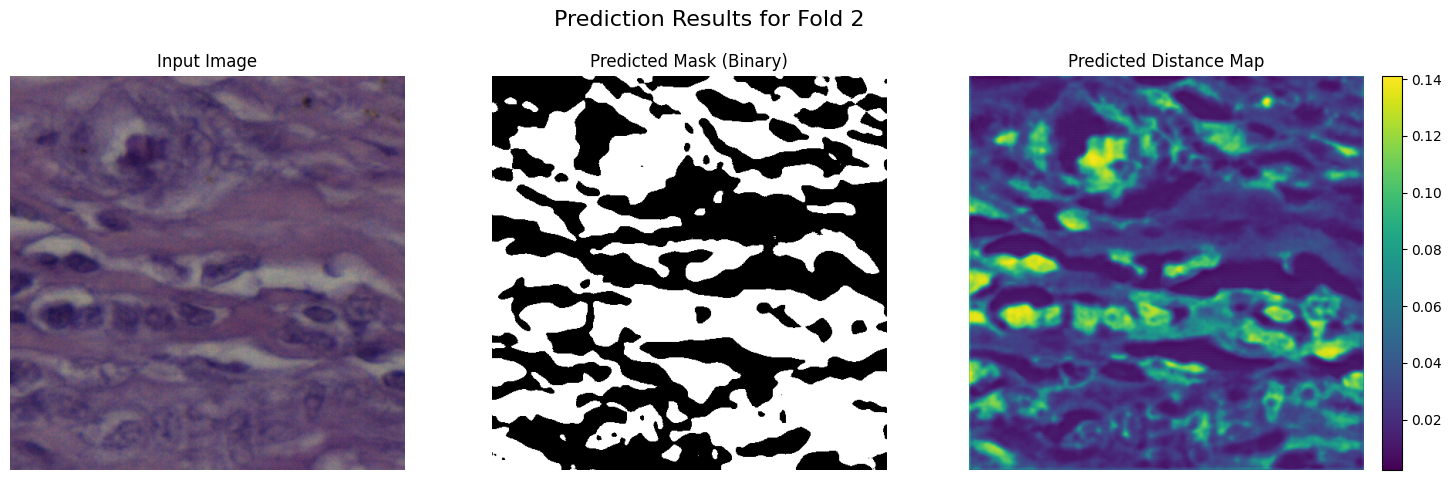

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Prepare the Prediction Generator ---
# IMPORTANT: Use batch_size=1 for easy visualization of a single image.
# Augment MUST be False for prediction.
predict_generator = data_gen(test_img, test_mask, test_DIS,
                             batch_size=1, 
                             p=1, # Placeholder value for p
                             size_row=opts['crop_size'], size_col=opts['crop_size'],
                             augment=False, 
                             BACKBONE_model=None, # Use None or correct value from opts
                             use_pretrain_flag=0) # Use 0 or correct value from opts

# --- 2. Extract One Batch for Prediction and True Targets ---
# X_test: The image input (normalized)
# Y_test_true: The dictionary of true targets (normalized)
X_test, Y_test_true = next(predict_generator) 

# --- 3. Generate Predictions ---
# The model returns a list: [output_dis, output_seg]

model.load_weights(opts['model_save_path'] + 'unet_2.weights.h5')

predictions = model.predict(X_test)

# Separate the outputs
output_dis_pred = predictions[0]
output_seg_pred = predictions[1]

# --- 4. Post-Process for Visualization ---
# Convert normalized input image back to 0-255 uint8 for display
input_img_display = (X_test[0] * 255).astype(np.uint8)

# Convert predicted probabilities to a binary mask (0 or 255)
# Squeeze the channel dimension (H, W, 1) -> (H, W)
predicted_mask_display = (output_seg_pred[0, :, :, 0] > 0.5).astype(np.uint8) * 255

# Get the predicted distance map for display (squeeze channel)
predicted_dis_map_display = output_dis_pred[0, :, :, 0]

# --- 5. Visualization ---

plt.figure(figsize=(15, 5))
plt.suptitle(f"Prediction Results for Fold {current_fold - 1}", fontsize=16)

# Plot 1: Input Image
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_img_display)
plt.axis('off')

# Plot 2: Predicted Segmentation Mask
plt.subplot(1, 3, 2)
plt.title("Predicted Mask (Binary)")
plt.imshow(predicted_mask_display, cmap='gray')
plt.axis('off')

# Plot 3: Predicted Distance Map
plt.subplot(1, 3, 3)
plt.title("Predicted Distance Map")
# Use 'viridis' or 'jet' colormap for regression outputs
plt.imshow(predicted_dis_map_display, cmap='viridis') 
plt.colorbar(fraction=0.046, pad=0.04) # Add color scale
plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()